# Introduction

The world has changed dramatically in the last two years, since COVID-19 came into our lives. Social norms, events and regulations have been adjusted and reshaped to suit the new reality that we are living in. This is also true for sports events, in which players and teams that were used to perform in front of tens of thousands of fans, now needed to compete in empty stadiums and arenas. A question that could be raised is how this affected home and away teams, now that their fans are not there to support them.

In this analysis, I look at two NBA seasons - 2019/2020 and 2020/2021, to examine the differences in perfomance of teams and players under these unique circumstances. I used the database of Basketball reference (www.basketball-reference.com).

In the 2019/2020 season, most of the season was played regularly with no limitations of fans attendance. The playoffs of this season, however, was played under closed doors in the same location, without any attendance. The 2020/2021 season saw significant limitations in fans attendance, with some teams not being permitted to allow any, while for the other teams it varied, but no team could allow more than 25% of their arena's capacity (and for most teams this number was smaller). In the playoffs, the limitations were reduced and teams could allow between 35%-70% of the arena's capacity, depending on the team.

How did these changes, that have never occurred in the league's history, would impact the teams winning rate at their arena? We will compare between the seasons to check the correlations between these variables, as well as comparing key metrics (points, rebounds, % field goals etc.).

In addition, we will run a model evaluation for both seasons to see which model predicts better based on home wins. We will consturct a matrix data visaulization to identify patterns between players positions (small guard, center etc.) and key metrics, and lastly use dimensionality reduction to examine performance of the top players in the league in both seasons, and see how they diffrentiate.

It is important to notice that while that this analysis is mostly exploratory (and predictive in some cases). There are many factors that aren't taken into account that are beyond the scope of this project. Therefore it wouldn't be advisable to assume casual inference. With that being said, the fact that a siginifcant factor (fans attendance) is so different between the two seasons in an unprecedented way, could provide useful insights that would be worth further exploring.

## Ranking and average attendance comparison

We will start with a high-level overview and comparison between the two regular seasons (without playoffs), checking correlation between overall ranking, average attendance and trends in the change between the seasons.

We will import to csv files - one for each season - with the overall ranking and average attendance of each team.

In [1]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import requests
import lxml
from bs4 import BeautifulSoup
import matplotlib.ticker as mticker
import warnings
import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
warnings.filterwarnings("ignore")

In [2]:
# Creating a function that will convert the csv files of both seasons, remove columns and make 
# naming and numerical adjustments

def importing_data(file):
    '''Takes a file as an argument, converts to dataframe, cleans and orders it
    '''
    
    try:
        x = pd.read_csv(file)

        x.at[30, 'Rank'] = 'Total'
        x.at[30, 'Team'] = '-'
        x.rename(columns={'Attend./G': 'Avg. Attend.'}, inplace=True)
        x.at[30, 'W'] = x['W'].sum()
        x.at[30, 'L'] = x['L'].sum()
        x['Team'] = x['Team'].map(lambda x: x.rstrip('*'))
        x.drop('Arena', 1, inplace=True)
        x.drop('Age', 1, inplace=True)
        x.fillna(0, inplace=True)
        x['Rank'][0:30] = x['Rank'][0:30].astype(int)
        x['W'] = x['W'].astype(int)
        x['L'] = x['L'].astype(int)
        x['Attend.'] = x['Attend.'].astype(int)
        x['Avg. Attend.'] = x['Avg. Attend.'].astype(int)
    except:
        pass

    return x

In [3]:
# Importing nba_2020 and nba_2021 advanced stats report from BS - which have data about fans attendancs
# Saving the files as dataframes and sorting them by average attendance

df_2020 = importing_data('nba_season_2020_with_attendance.csv')
df_2021 = importing_data('nba_season_2021_with_attendance.csv')

df_nba_2020_season_by_attend = df_2020[0:30].sort_values('Avg. Attend.', ascending= False)
df_nba_2021_season_by_attend = df_2021[0:30].sort_values('Avg. Attend.', ascending= False)

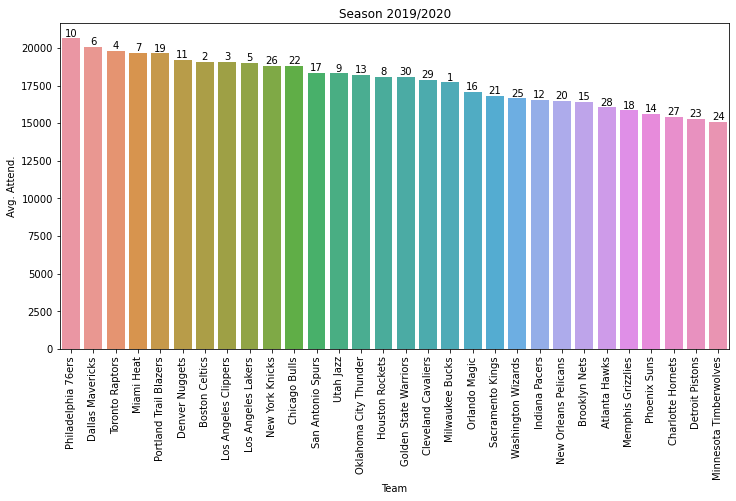

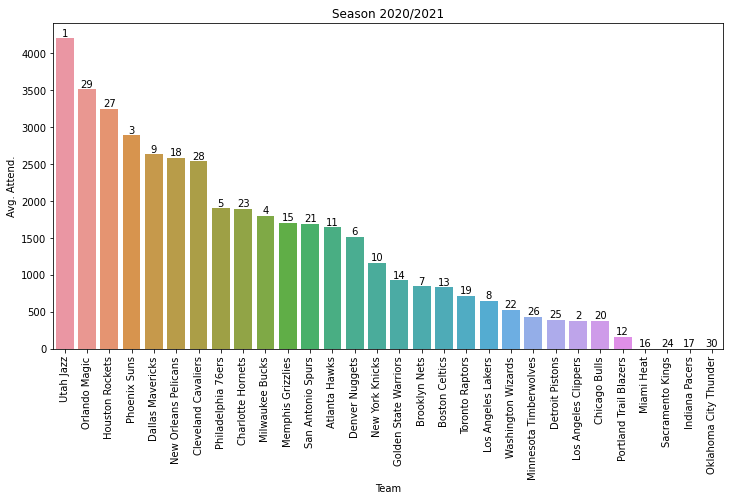

In [4]:
# Plotting both dataframes by average attendance and the overall ranking of each team on the top of the bar

# 2019/20 season
fig, axes = plt.subplots(figsize=(12,6))

ax_2020_by_attend = sns.barplot(data=df_nba_2020_season_by_attend, x=df_nba_2020_season_by_attend['Team'], 
                 y= df_nba_2020_season_by_attend['Avg. Attend.'],label = 'Attendance')
ax_2020_by_attend.set_xticklabels(ax_2020_by_attend.get_xticklabels(),rotation = 90)

for p,date in zip(ax_2020_by_attend.patches, df_nba_2020_season_by_attend['Rank']):
    ax_2020_by_attend.annotate(date, xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', label = 'Rank')
    
plt.title('Season 2019/2020')
plt.show()

# 2020/21 season
fig, axes = plt.subplots(figsize=(12,6))

ax = sns.barplot(data=df_nba_2021_season_by_attend, x=df_nba_2021_season_by_attend['Team'], 
                 y= df_nba_2021_season_by_attend['Avg. Attend.'],label = 'Attendance')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


for p,date in zip(ax.patches, df_nba_2021_season_by_attend['Rank']):
    ax.annotate(date, xy=(p.get_x()+p.get_width()/2, p.get_height()),ha='center', va='bottom', label = 'Rank')
plt.title('Season 2020/2021')
plt.show()

We can see the huge difference between the average attandance. In seaon 2019/2020 no team had an average attendance of less than 15,000, and the total average was almost 18,000. In season 2020/2021, due to the limitations only 7 teams averaged more than 2,000 and the average was less than 1,500. Let's see the correlation between the ranking and average attendance.

In [5]:
# Creating a list of the teams names only, as well as arrays of the rankings and average attendance

teams_2020 = df_2020[0:30]['Team']
teams_2020 = teams_2020.values
ranking_only_2020 = df_2020.iloc[0:30, 0].values.astype(int)
attend_only_2020 = df_2020.iloc[0:30, 5].values

teams_2021 = df_2021[0:30]['Team']
teams_2021 = teams_2021.values
ranking_only_2021 = df_2021.iloc[0:30, 0].values.astype(int)
attend_only_2021 = df_2021.iloc[0:30, 5].values

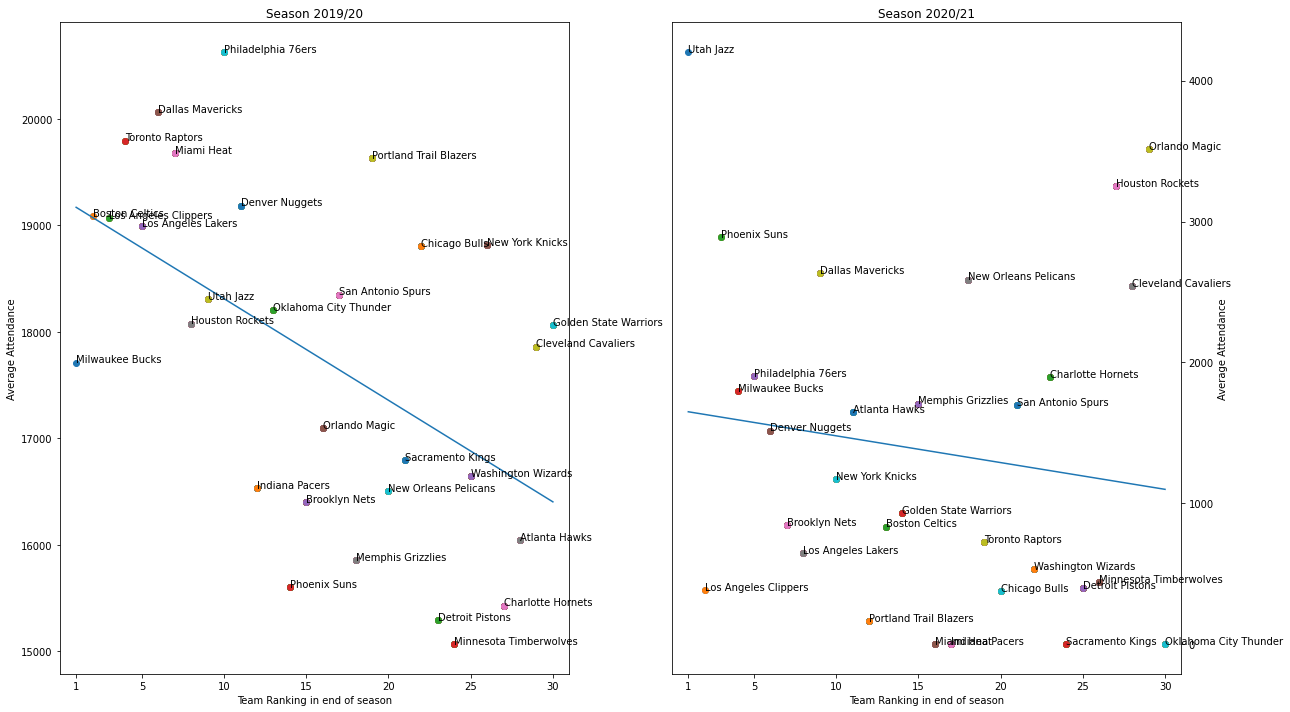

In [6]:
# Plotting the teams rankings on the x axis and the average attendance on the y axis, to check correlation 
# between attendance and ranking. Showing both seasons side by side

plt.figure(figsize = (18,10))

# Season 2019/20
ax3 = plt.subplot(1,2,1)
for i in range(30):
    ax3.scatter(x = df_2020[i:30]['Rank'], y = df_2020[i:30]['Avg. Attend.'])
    
for idx, row in df_2020[0:30].iterrows():
    ax3.annotate(row['Team'], (row['Rank'], row['Avg. Attend.']))
    
m, b = np.polyfit(ranking_only_2020, attend_only_2020, 1)
ax3.plot(ranking_only_2020, m*ranking_only_2020 + b)
plt.title('Season 2019/20')
plt.xlabel('Team Ranking in end of season')
plt.xticks([1,5,10,15,20,25,30])  
plt.xlim(-0,31)
plt.ylabel('Average Attendance')
plt.tight_layout()

# Season 2020/21
ax2 = plt.subplot(1,2,2)
for i in range(30):
    ax2.scatter(x = df_2021[i:30]['Rank'], y = df_2021[i:30]['Avg. Attend.'])
    
for idx, row in df_2021[0:30].iterrows():
    ax2.annotate(row['Team'], (row['Rank'], row['Avg. Attend.']))

m, b = np.polyfit(ranking_only_2021, attend_only_2021, 1)

ax2.plot(ranking_only_2021, m*ranking_only_2021 + b)
plt.xlabel('Team Ranking in end of season')
plt.ylabel('Average Attendance')
plt.title('Season 2020/21')
plt.xticks([1,5,10,15,20,25,30])  
plt.xlim(0,31)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.tight_layout()
plt.show()

We can see a strong correlation between average attendance and ranking in season 2019/2020, and unsurprisingly there isn't much correlation in the year 2020/2021. Of course, the fact there is correlation in 2019/2020 could be from a reveresed cause - if the team is better the attendance grows. Let's examine the change in ranking of each team between the two seasons and see if there are any trends worth mentioning:

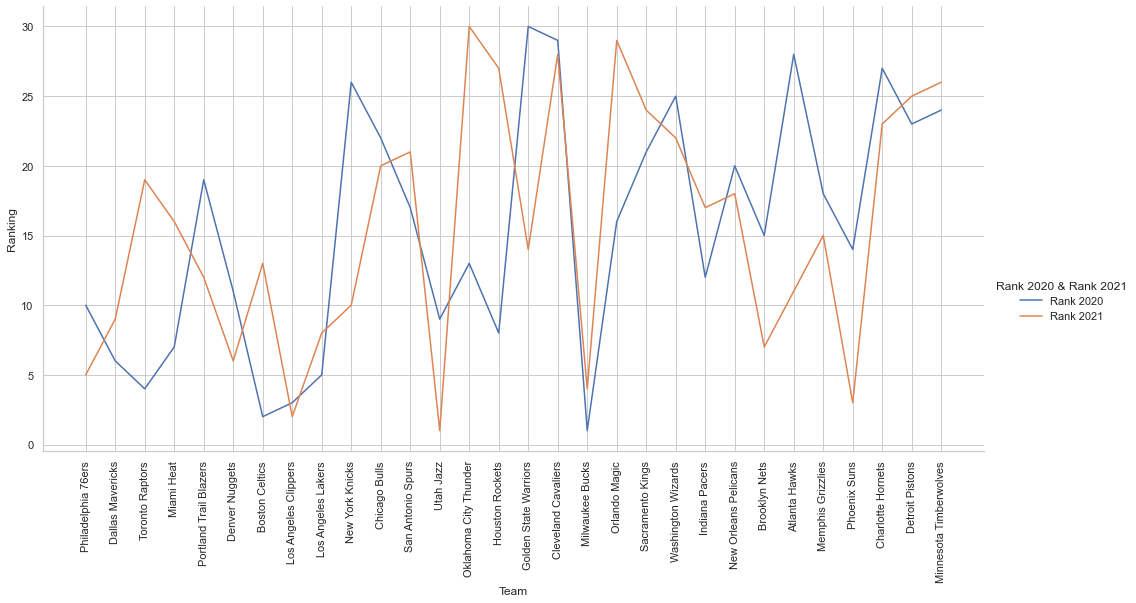

In [7]:
# We First merge the two original dataframes
df_seasons_2020_2021 = pd.merge(df_2020, df_2021, on='Team')

# Rename the columns
df_seasons_2020_2021.rename(columns={'Rank_x': 'Rank 2020', 'W_x': 'Wins 2020', 'L_x': 'Loses 2020',
                                     'Attend._x':'Attend. 2020', 'Avg. Attend._x':'Avg. Attend. 2020',
                                     'Rank_y': 'Rank 2021', 'W_y': 'Wins 2021', 'L_y': 'Loses 2021',
                                     'Attend._y':'Attend. 2021', 'Avg. Attend._y':'Avg. Attend. 2021'}, inplace=True)

# Reorder the columns
df_seasons_2020_2021 = df_seasons_2020_2021[['Team', 'Rank 2020', 'Wins 2020', 'Loses 2020', 'Attend. 2020',
                                             'Avg. Attend. 2020','Rank 2021', 'Wins 2021', 'Loses 2021',
                                             'Attend. 2021', 'Avg. Attend. 2021']]


# Create a new dataframs sorted by attendace of 2020
df_seasons_2020_2021_attend = df_seasons_2020_2021[0:30].sort_values(['Avg. Attend. 2020'], ascending=False)

# Checking difference in ranking between years
df_seasons_2020_2021_melted = df_seasons_2020_2021_attend[['Team', 'Rank 2020', 'Rank 2021']].melt("Team",var_name="Rank 2020 & Rank 2021",value_name="Ranking")
sns.set(style="whitegrid", color_codes=True)
ax_relpot = sns.relplot(data=df_seasons_2020_2021_melted, x="Team", y="Ranking", hue="Rank 2020 & Rank 2021",kind="line",height=7, aspect=2)
ax_relpot.set_xticklabels(rotation=90)
plt.show()

The plot is sorted from the team with most attendance in season 2019/2020 (so Philadephia 76ers had the biggest average attendance in that season). We can't identify here an apparent trend in the change of rankings - for the top 10 teams with average attendance, 5 ranked lower in 2020/2021 compared to the previous year, and 5 higher.

This is a high level overview that takes into account the general ranking (including all games, home and away, of each team). Let's break it down and look at teams performances by their home record only.

 ## 2. Home win rate - correlation, distribution and variance

We will now analyze the relationships between the teams home win rate in each season and how they differ in their distribution. We will scrape from BS the pages that contatin the data about the teams games in each season, the score and whether it was an away or home game. We will then create a dataframe based on home wins rate and see what's the difference in home wins rate between the seasons, and how it differs for each team as well. 

Surprisingly, BS doesn't have an overview of home/away wins records for each team (like the points metrics for example), rather it's only accessable on the page of each team. So this required some extended scraping and cleaning of the data.

In [8]:
# Scraping the teams abbreviations from wikipedia - so we can sync it with the abbreviations of the teams
# pages on BS

url_teams = 'https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations'
page2=requests.get(url_teams)
soup2 = BeautifulSoup(page2.content, "lxml")
names =  soup2.find_all('table')[0]
df_names = pd.read_html(str(names))[0]

# Creating a list of the abbreviated names
name_abv = []
name_abv.extend(list(df_names[0][1::]))

# Changing 3 teams names so they're aligned with the BS abbreviations (they have different abbreviations on wikipedia)  
name_abv[1] = 'BRK'
name_abv[3] = 'CHO'
name_abv[23] = 'PHO'

In [9]:
def scrape_teams_data(st):
    '''The argument is the ending of the pages name, there is one for 2020 and one for 2021
    '''
    
    # Creating dataframes for each season with all the teams games, and then group by home wins and sort them
    # by home win rate
    
    df_teams_data = []
    for i in name_abv:
        try:
            url='https://www.basketball-reference.com/teams/'
            page=requests.get(url+str(i)+str(st))
            soup = BeautifulSoup(page.content, "lxml")
            tab = soup.find_all('table')[0]
            if i in name_abv:
                df = pd.read_html(str(tab))[0]
                df_teams_data.append([i, df])
        except IndexError:
            continue

    # Adding to each team's dataframe another column that will have the name of the team (so for each row we know
    # which team it is), and then appending to a dataframe without the first index of each dataframe, 
    # which is the team's abbrevation, since we have this now as a column
    df_data_only = []
    for i in df_teams_data:
        i[1].insert(1,'Team', i[0])
        df_data_only.append(i[1])

    # Concating all dataframes into one dataframe
    df_teams_all = pd.concat(df_data_only)
    
    # Removing columns that aren't needed:
    df_teams_all = df_teams_all.drop('Start (ET)', 1).drop('Unnamed: 3', 1).drop('Unnamed: 4', 1)
    df_teams_all = df_teams_all.drop('Unnamed: 8', 1).drop('Tm', 1).drop('Opp', 1).drop('Streak', 1).drop('Notes', 1)

    # Renaming the relevant columns - home/away and wins/loses
    df_teams_all.rename(columns={'Unnamed: 5': 'Home/Away', 'Unnamed: 7': 'Win/Lose'}, inplace=True)

    # Removing the first characters (the day of the week) from the date rows:
    df_teams_all['Date'] = df_teams_all['Date'].str[5:]

    # Changing the values of the home/away column - @ is for an away game, and nan is a home game
    df_teams_all["Home/Away"].replace({"@": "Away"}, inplace=True)
    df_teams_all["Home/Away"].replace(np.nan, 'Home', regex=True, inplace=True)

    # There are some rows that served as buffers on the website's pages, so these will still have in some cells nan - 
    # we want to remove these rows
    df_teams_all = df_teams_all.dropna()
            
    return df_teams_all

In [10]:
# Saving the two dataframes for each season
df_all_teams_2020 = scrape_teams_data('/2020_games.html')
df_all_teams_2021 = scrape_teams_data('/2021_games.html')

In [11]:
# Creating a function that will merge two dataframes - the dataframe with the games of all teams,
# and the dataframe with the overview of all teams that includes average attendance:

def home_wins_lose_teams(df, df2):
    """Two arguments - the dataframe with the games of all teams, and the dataframe with
    the average attendance of each team. The function merges them and sorts the merged 
    dataframe by home win rate
    """
    
    # Creating a dataframe with only the home games of each team:
    df_team_win_lose = df.groupby(['Team','Win/Lose', 'Home/Away']).size().sort_values(ascending=False) \
      .reset_index(name='Total')
    
    # Leaving in the dataframe only the home games
    df_team_win_lose = df_team_win_lose.sort_values(['Home/Away', 'Team', 'Win/Lose'], ascending=False)[0:60]
    df_team_win_lose.reset_index(inplace=True)

    # Creating a dataframe sorted by the most home wins:
    df_sort_by_wins = df_team_win_lose.sort_values(['Win/Lose','Total'], ascending=(False, False))

    # Calculating the season's ratio of home wins and losses in total 
    try:
        for i in df_sort_by_wins['Team']:
            df_sort_by_wins.insert(5, '% Home wins', 
                                      df_sort_by_wins['Total']/(df_sort_by_wins.loc[df_sort_by_wins['Team'] == i, 'Total'].sum())*100)
    except:
        pass                       
                                     
    
    # We want to merge this sorted dataframe with the dataframe with the average attendance, so we need to change 
    # the name of the teams in this dataframe so they're aligned with the attendance dataframe:
    
    # Changing the names of the teams so they're the same as the names in nba_2020_season dataframe
    df_sort_by_wins.replace({"PHI": "Philadelphia 76ers", "MIL": "Milwaukee Bucks", 
                             "MIA": "Miami Heat", "LAC": "Los Angeles Clippers",
                             "TOR": "Toronto Raptors", "BOS": "Boston Celtics",
                             "LAL": "Los Angeles Lakers", "DEN": "Denver Nuggets",
                             "IND": "Indiana Pacers", "HOU": "Houston Rockets",
                             "UTA": "Utah Jazz", "OKC": "Oklahoma City Thunder",
                             "POR": "Portland Trail Blazers", "BRK": "Brooklyn Nets",
                             "SAS": "San Antonio Spurs", "MEM": "Memphis Grizzlies",
                             "DAL": "Dallas Mavericks", "ORL": "Orlando Magic", 
                             "SAC": "Sacramento Kings", "WAS": "Washington Wizards",
                             "PHO": "Phoenix Suns", "NOP": "New Orleans Pelicans",
                             "CHI": "Chicago Bulls", "ATL": "Atlanta Hawks",
                             "DET": "Detroit Pistons", "NYK": "New York Knicks",
                             "CHO": "Charlotte Hornets", "CLE": "Cleveland Cavaliers",
                             "MIN": "Minnesota Timberwolves", "GSW": "Golden State Warriors"}, inplace=True)

    # Merging df_sort_by_wins and the attendance dataframe (the argument df2) to one dataframe:
    df_sort_by_win_rate_attend = pd.merge(df_sort_by_wins[0:30], df2, on='Team')
    df_sort_by_win_rate_attend['Rank']= df_sort_by_win_rate_attend['Rank'].astype(int)
    
    return df_sort_by_win_rate_attend
    

In [12]:
# Saving the function as dataframes from both seasons:
df_home_total_2020 = home_wins_lose_teams(df_all_teams_2020, df_nba_2020_season_by_attend)
df_home_total_2021 = home_wins_lose_teams(df_all_teams_2021, df_nba_2021_season_by_attend)

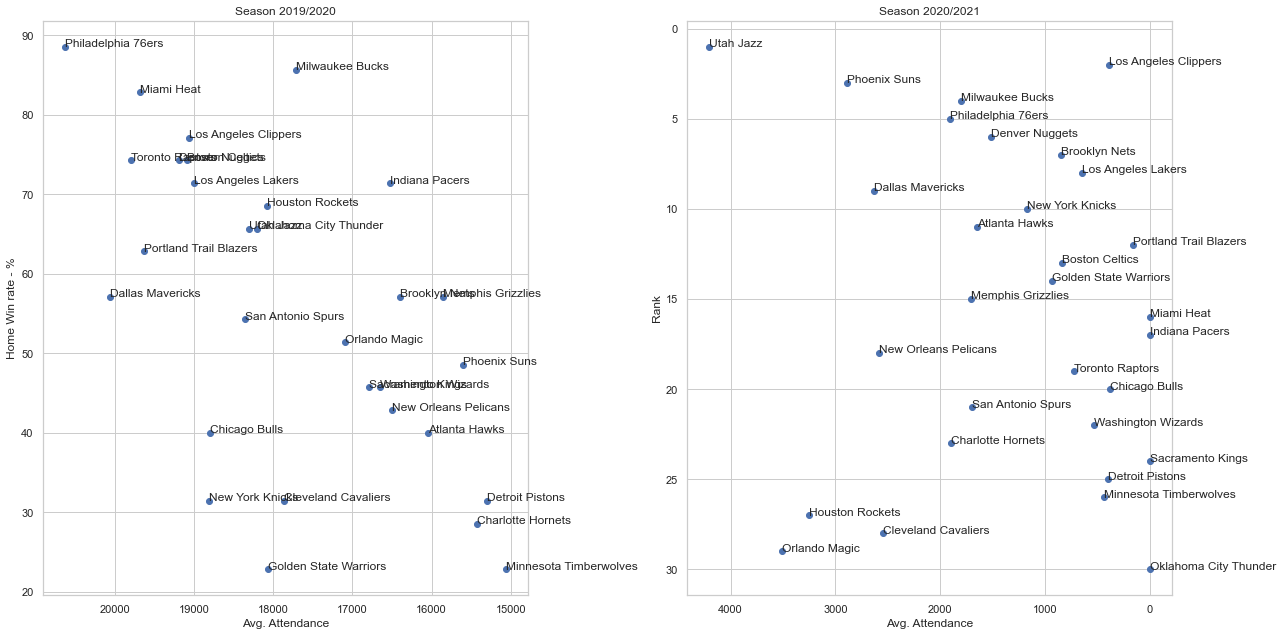

,Rank,% Home wins,Avg. Attend.
Rank,1.000000,0.902155,0.550167
% Home wins,0.902155,1.000000,0.616697
Avg. Attend.,0.550167,0.616697,1.000000


In [13]:
# Plotting the home win rate together with average attendance for both seasons

fig, (ax,ax3) = plt.subplots(1,2, figsize=(18,9))
ax.scatter(df_home_total_2020['Avg. Attend.'], df_home_total_2020['% Home wins'])
ax.invert_xaxis()
ax.set_xlabel('Avg. Attendance')
ax.set_ylabel('Home Win rate - %')
ax.set_title('Season 2019/2020')

for idx, row in df_home_total_2020.iterrows():
    ax.annotate(row['Team'], (row['Avg. Attend.'], row['% Home wins']))
    
ax3.scatter(df_home_total_2021[0:30]['Avg. Attend.'], df_home_total_2021[0:30]['Rank'].astype(int))
ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.set_xlabel('Avg. Attendance')
ax3.set_ylabel('Rank')
ax3.set_title('Season 2020/2021')


for idx, row in df_home_total_2021.iterrows():
    ax3.annotate(row['Team'], (row['Avg. Attend.'], row['Rank']))

plt.tight_layout()
plt.show()

# Checking correlation between ranking, home wins and average attendance for season 2019/20
sort_by_win_rate_attend_cor = df_home_total_2020[['Team', 'Rank', '% Home wins', 'Avg. Attend.']]
sort_by_win_rate_attend_cor["% Home wins"] = sort_by_win_rate_attend_cor["% Home wins"].rank(ascending=False).apply(np.floor).astype(int)
sort_by_win_rate_attend_cor["Avg. Attend."] = sort_by_win_rate_attend_cor["Avg. Attend."].rank(ascending=False).astype(int)
corr = sort_by_win_rate_attend_cor.corr()
corr.style.background_gradient(cmap='coolwarm')

We see a very strong correlation between % home wins and rank, which makes sense of course. So how can we define better the impact of average attendance on home games? Let's have a look at the total home win rate of both seasons and see what's the difference there. Assuming average attendnace playes a signifcant role, we would expect to see a change. 

In [14]:
# Comparing the total home win/lose rate of both seasons

def home_win_lose_total(df):
    """Takes a dataframe, returns total number and ratio of home wins and loses of entire season
    """
    # dataframe grouped by home and away recores
    df_home_rate = df.groupby(['Home/Away', 'Win/Lose']).size().sort_values(ascending=(False)) \
      .reset_index(name='Total')

    # Leaving only the first two rows (the other two are the same data, just switching between the columns)
    df_home_rate = df_home_rate.sort_values(['Home/Away'], ascending=False)[0:2]

    # Calculating the % of home wins and loses in a new column:
    df_home_rate.insert(3,'%', 'place_holder')
    df_home_rate.at[1, '%'] = df_home_rate['Total'][1]/(df_home_rate['Total'][1]+df_home_rate['Total'][3])*100
    df_home_rate.at[3, '%'] = df_home_rate['Total'][3]/(df_home_rate['Total'][1]+df_home_rate['Total'][3])*100
    
    return df_home_rate

In [15]:
# Saving the function as dataframes from both seasons:
df_home_win_rate_2020 = home_win_lose_total(df_all_teams_2020)
df_home_win_rate_2021 = home_win_lose_total(df_all_teams_2021)

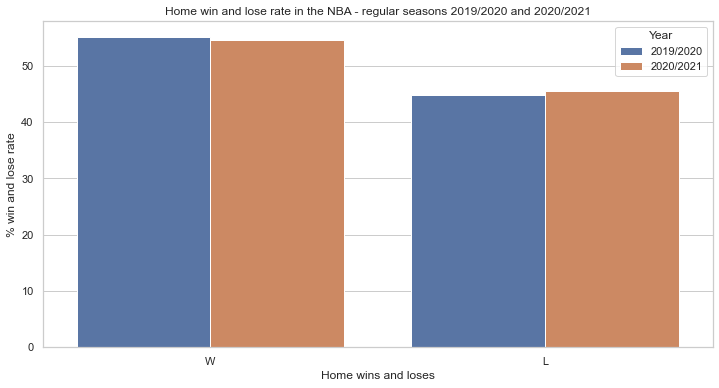

In [16]:
# Concating the total home wins and loses of both seasons
df_win_loses_2021_2021_con = pd.concat([df_home_win_rate_2020, df_home_win_rate_2021]).reset_index()

# Adding a year column to determine the wins and loses of each year:
df_win_loses_2021_2021_con.insert(0, 'Year', 'p')

# Adding a column for the years
df_win_loses_2021_2021_con.at[0, 'Year'] = '2019/2020'
df_win_loses_2021_2021_con.at[1, 'Year'] = '2019/2020'
df_win_loses_2021_2021_con.at[2, 'Year'] = '2020/2021'
df_win_loses_2021_2021_con.at[3, 'Year'] = '2020/2021'

# Plotting both years win rate to examine the difference between them
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data=df_win_loses_2021_2021_con, x='Win/Lose', 
                 y= '%',hue = 'Year')
plt.xlabel('Home wins and loses')
plt.ylabel('% win and lose rate')
plt.title('Home win and lose rate in the NBA - regular seasons 2019/2020 and 2020/2021')
plt.show()

Surprisingly, there's barely any difference between the home wins/lose rates! Let's see how this difference is distributed between the teams:

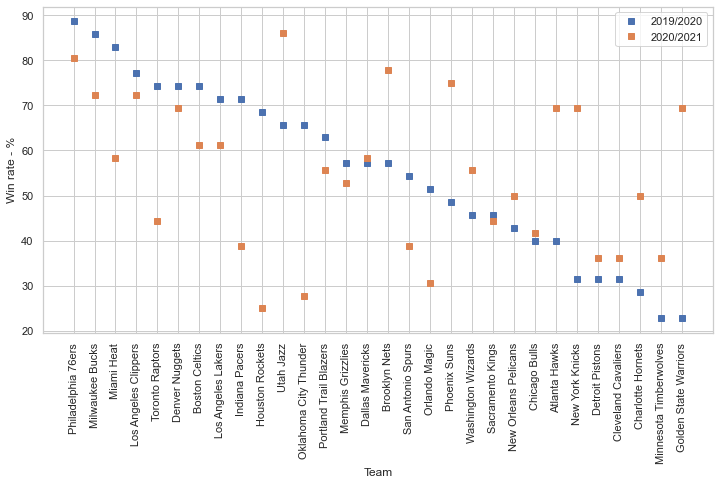

In [17]:
# Examining the difference for each team - the diff in win rate between both seasons

plt.subplots(figsize=(12,6))

df1_a = df_home_total_2020['Team'].tolist()
df1_b = df_home_total_2020['% Home wins'].tolist()
df2_a = df_home_total_2021['Team'].tolist()
df2_b = df_home_total_2021['% Home wins'].tolist()

plt.plot(df1_a, df1_b, 's') 
plt.plot(df2_a, df2_b, 's')
plt.xlabel('Team')
plt.ylabel('Win rate - %')
plt.xticks(rotation=90)
plt.legend(['2019/2020', '2020/2021'])
plt.show()

This is interesting - while the ratio of wins-loses between the seasons is almost exactly the same, we can notice the variance between the teams - the home win rate of almost all of the teams in the top half (15 teams) has decreased in the following year, and we can see an opposite trend with the teams of the bottom half. 

So while the average hasn't changed, this graph suggets that attendance does have a big impact - but not necessarily always for the better. It is reasonable to think that for underperforming teams, the fans could have more of a negative effect than positive. Of course this is a pretty loose estimation, but it is something that could be of interest for future studies.

We now check the distribution of the home wins throughout the seasons. We eliminate games from July and August of 2019/2020 season, since these were after the league went on a COVID break of about 4 months and were with no attendance.

In [18]:
# Changing dates to datetime and creating dataframes with only home wins of all teams:
df_all_teams_2020['Date'] = pd.to_datetime(df_all_teams_2020.Date)
df_all_teams_2021['Date'] = pd.to_datetime(df_all_teams_2021.Date)

df_teams_all_2020_home_games_wins = df_all_teams_2020
df_teams_all_2020_home_games_wins = df_teams_all_2020_home_games_wins.loc[df_teams_all_2020_home_games_wins['Home/Away'] == 'Home']
df_teams_all_2020_home_games_wins = df_teams_all_2020_home_games_wins.loc[df_teams_all_2020_home_games_wins['Win/Lose'] == 'W']

df_teams_all_2021_home_games_wins = df_all_teams_2021
df_teams_all_2021_home_games_wins = df_teams_all_2021_home_games_wins.loc[df_teams_all_2021_home_games_wins['Home/Away'] == 'Home']
df_teams_all_2021_home_games_wins = df_teams_all_2021_home_games_wins.loc[df_teams_all_2021_home_games_wins['Win/Lose'] == 'W']

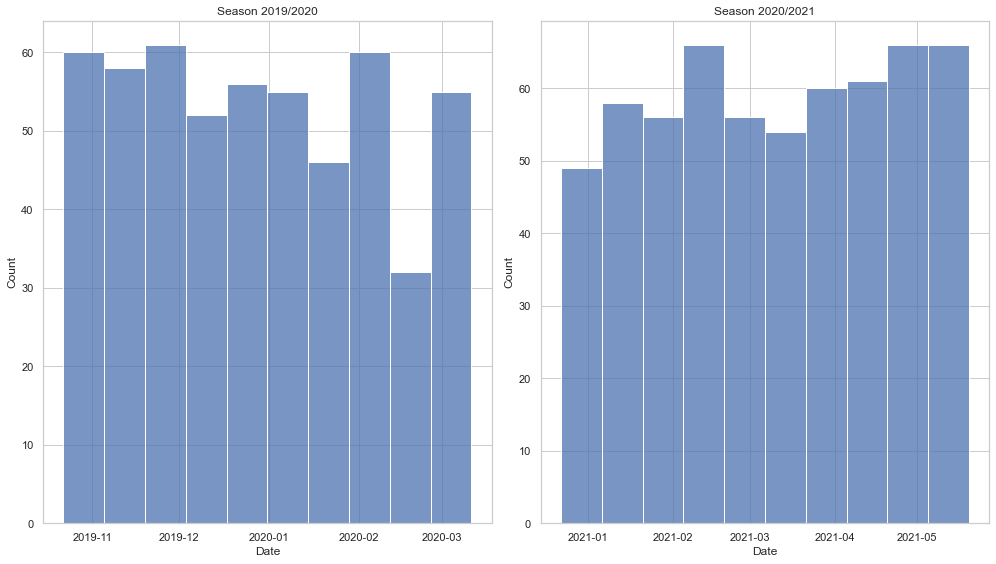

In [19]:
# Plotting with histogram the distrbution of home wins throughout the seasons
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,8))

ax1 = sns.histplot(df_teams_all_2020_home_games_wins['Date'].loc[df_teams_all_2020_home_games_wins['Date'] < '2020-07'], color='b', bins= 10, ax=ax1)
ax1.set_title('Season 2019/2020')

ax2= sns.histplot(df_teams_all_2021_home_games_wins['Date'],color='b', bins= 10, ax=ax2)
ax2.set_title('Season 2020/2021')
plt.tight_layout()
plt.show()

Interesting to see the difference in the home wins distribution - while there is a decrease in season 2019/2020 as the season goes along, we see an opposite ternd in 2020/2021. Could imply that in the beginning of 2020/2021 the players were not used to the scenario
of home games without fans and this was reflected in the games.
Lastly for this section, we check the home/away ratio in the 2020/2021 playoffs - where limitations of attendance were far less restrictive than regular season

In [20]:
# For the 2021 playoffs we want to look at the home and away games, so we will scrape the data from BS

url3 = 'https://www.basketball-reference.com/playoffs/NBA_2021.html#all_totals_team-opponent'

page3=requests.get(url3)
soup3 = BeautifulSoup(page3.content, "lxml")

nba_2021_playoff_scrape = []
tab3 = soup3.find_all('table')[1:16]
df4 = pd.read_html(str(tab3))
nba_2021_playoff_scrape.extend(df4)

season_2021_playoff_games = pd.concat(nba_2021_playoff_scrape)

# Removing index and defining whether the home or away team won the game
season_2021_playoff_games = season_2021_playoff_games.reset_index(drop=True)

for i, row in season_2021_playoff_games.iterrows():
    if int(row[3]) < int(row[5]):
        season_2021_playoff_games.at[i, 6] = 'Home'
    else:
        season_2021_playoff_games.at[i,6] = 'Away'

# Renaming columns
season_2021_playoff_games.rename(columns={0:'G', 1:'Date', 2:'Away team', 3:'Away team score', 4:'Home team',
                                         5:'Home team score', 6:'Winner'}, inplace=True)

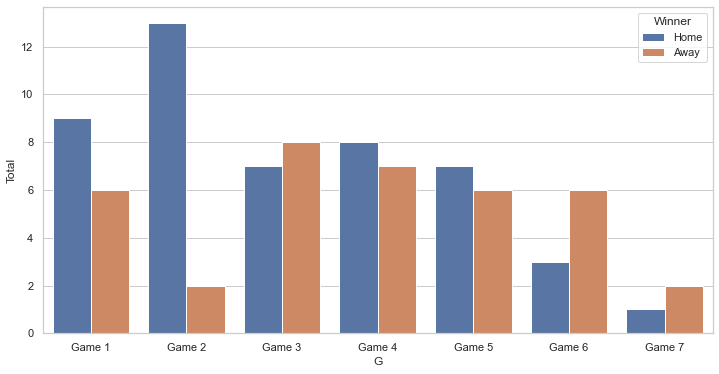

,Winner,Total
G,,
Game 1,Home,9
Game 1,Away,6
Game 2,Home,13
Game 2,Away,2
Game 3,Away,8
Game 3,Home,7
Game 4,Home,8
Game 4,Away,7
Game 5,Home,7


In [21]:
# Sorting by home games

season_2021_playoff_games_home = season_2021_playoff_games.groupby(['G', 'Winner']).size().sort_values(ascending=False) \
  .reset_index(name='Total')
season_2021_playoff_games_home.sort_values('G', inplace=True)

fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data = season_2021_playoff_games_home,
                x= 'G', y = 'Total', hue = 'Winner')

plt.show()
season_2021_playoff_games_home.set_index('G')


The home win ratio is very similar to regular season (56%), but it's interesting to notice the balance for games 5,6 and 7 - which are the most important and decisive games. In this case the away teams have 15 wins, and the home teams only 11. This is a very small sample, but could also be an potential starting point for further analysis.

# 3. Comparing key metrics
In this section we will examine the key metrics in the NBA season, how do they differ between the seasons and what can we make from it in regards to the attendance difference?

In [22]:
# Importing the stats csv files
nba_2020_season_stats = pd.read_csv('nba_season_2020_stats.csv')
nba_2021_season_stats = pd.read_csv('nba_season_2021_stats.csv')

# Removing unwanted characters from the Team column and unwanted columns and renaming the rank column
nba_2020_season_stats['Team'] = nba_2020_season_stats['Team'].map(lambda x: x.rstrip('*'))
nba_2020_season_stats.rename(columns={'Rk': 'Rank'}, inplace=True)
nba_2020_season_stats.fillna(0, inplace=True)
nba_2021_season_stats['Team'] = nba_2021_season_stats['Team'].map(lambda x: x.rstrip('*'))
nba_2021_season_stats.rename(columns={'Rk': 'Rank'}, inplace=True)
nba_2021_season_stats.fillna(0, inplace=True)
nba_2020_season_stats.at[30, 'Rank'] ='0'
nba_2020_season_stats['Rank'][30] = 'Total'
nba_2020_season_stats['Rank'][0:30] = nba_2020_season_stats['Rank'][0:30].astype(int)

In [23]:
# Adding another column fo the year of each season
nba_2020_season_stats.insert(0, 'Year', '2019/2020')
nba_2021_season_stats.insert(0, 'Year', '2020/2021')

# Concating the dataframes
df_nba_2020_2021_season_stats_con = pd.concat([nba_2020_season_stats, nba_2021_season_stats])

# Adding a constant column for later visualization 
df_nba_2020_2021_season_stats_con.insert(1, 'Metric', 'Metric')

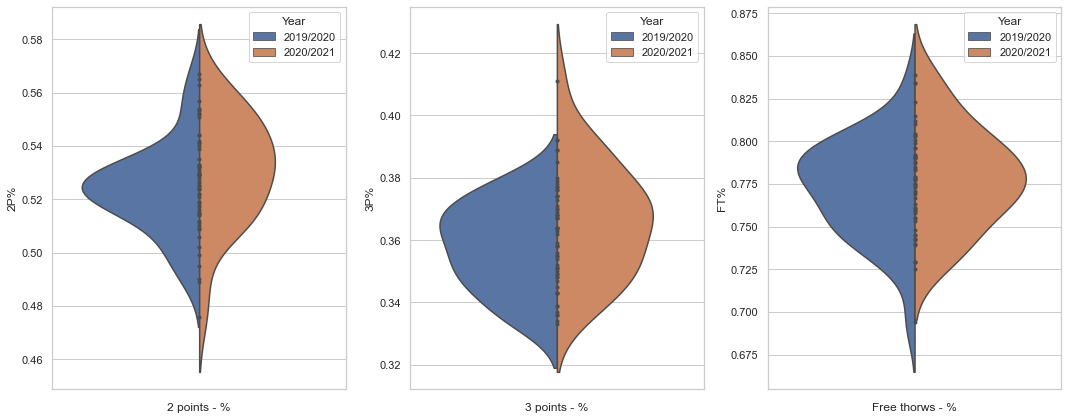

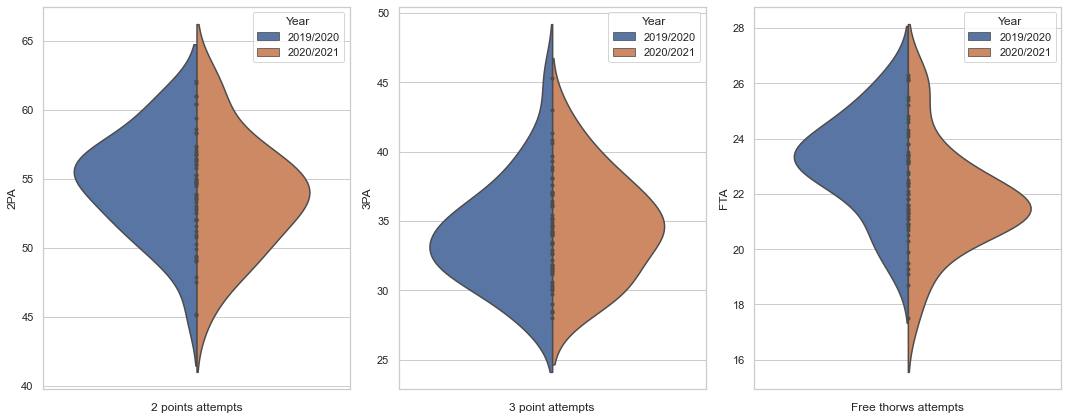

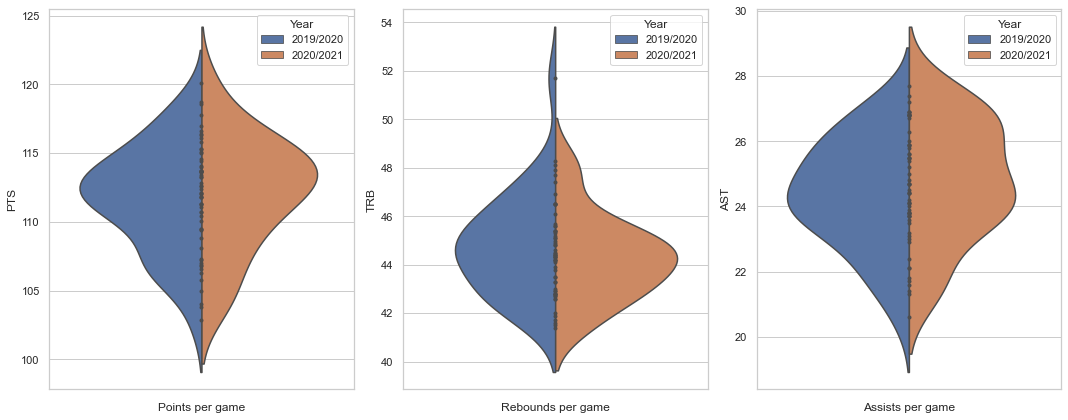

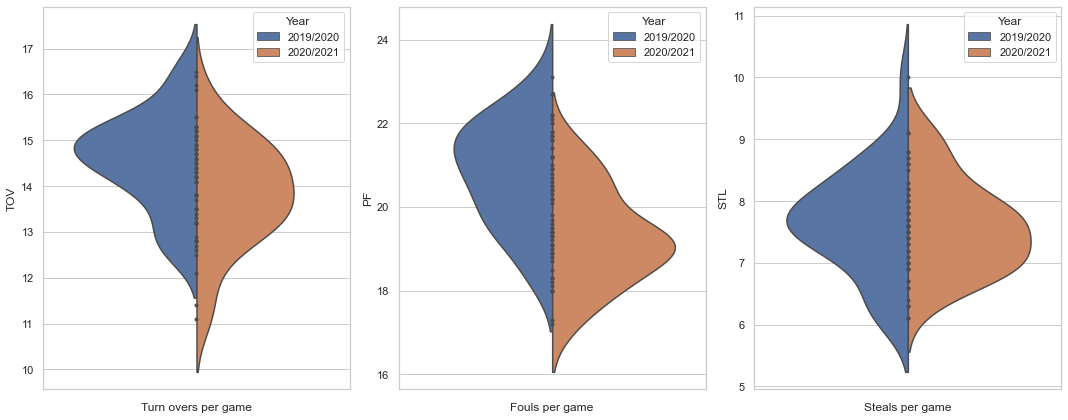

In [24]:
# We now use violin plot to see the difference in the key metrics between the seasons:

# Checking for 12 metrics the differnce between the seasons - % for 2 points, % for 3 points, % free throws,
# 2 points attempts, 3 points attempts, free throws attempts, points, rebounds, assists, turnovers,
# fouls and steals

fig, axes = plt.subplots(1,3,figsize=(15,6))
metrics = ['2P%', '3P%', 'FT%']
for i in range(3):
    sns.violinplot(data = df_nba_2020_2021_season_stats_con, x= 'Metric', y = metrics[i], hue = 'Year', points=10, widths=0.3,
              split = True,inner="points", ax =axes[i])
    axes[i].set_ylabel(metrics[i])
    axes[i].set(xticklabels=[])
    
axes[0].set_xlabel('2 points - %')
axes[1].set_xlabel('3 points - %')
axes[2].set_xlabel('Free thorws - %') 
plt.tight_layout()

fig, axes = plt.subplots(1,3,figsize=(15,6))
metrics = ['2PA', '3PA', 'FTA']

for i in range(3):
    sns.violinplot(data = df_nba_2020_2021_season_stats_con, x= 'Metric', y = metrics[i], hue = 'Year', points=10, widths=0.3,
              split = True,inner="points", ax =axes[i])
    axes[i].set_ylabel(metrics[i])
    axes[i].set(xticklabels=[])
    
axes[0].set_xlabel('2 points attempts')
axes[1].set_xlabel('3 point attempts')
axes[2].set_xlabel('Free thorws attempts') 
plt.tight_layout()

fig, axes = plt.subplots(1,3,figsize=(15,6))
metrics = ['PTS', 'TRB', 'AST']

for i in range(3):
    sns.violinplot(data = df_nba_2020_2021_season_stats_con, x= 'Metric', y = metrics[i], hue = 'Year', points=10, widths=0.3,
              split = True,inner="points", ax =axes[i])
    axes[i].set_ylabel(metrics[i])
    axes[i].set(xticklabels=[])
    
axes[0].set_xlabel('Points per game')
axes[1].set_xlabel('Rebounds per game')
axes[2].set_xlabel('Assists per game') 
plt.tight_layout()

fig, axes = plt.subplots(1,3,figsize=(15,6))
metrics = ['TOV', 'PF', 'STL']

for i in range(3):
    sns.violinplot(data = df_nba_2020_2021_season_stats_con, x= 'Metric', y = metrics[i], hue = 'Year', points=10, widths=0.3,
              split = True,inner="points", ax =axes[i])
    axes[i].set_ylabel(metrics[i])
    axes[i].set(xticklabels=[])
    
axes[0].set_xlabel('Turn overs per game')
axes[1].set_xlabel('Fouls per game')
axes[2].set_xlabel('Steals per game') 
plt.tight_layout()

plt.show()

For most metrics we see slightly higher averages in season 2020/2021. Two interesting metrics are fouls and turnovers - there were less turnovers on average in season 2020/2021, perhaps this has something to do with players being less pressured when they're not playing in front of an audience. There were also less fouls in this season - might indicate that the games are less intensed, without 15-20 thousands people jeering and cheering in the stands.

# 4. Model evaluation

Next we would like to examine how well we can predict home wins, based on the season averages metrics of each team, with the dependent variable is whether the team won or lost. For that, we will create a dataframe with all games of the teams, and define whether the home team won or lost. We will normalize the average metrics of each team for the season and use these as our samples to train and test different models. Besides checking how well we can predict it, it will also be interesting to see if there's a difference between the seasons predictions, where the home win ratio was very similiar but the variance between teams was significant.

In [25]:
# Scraping the data of all games from seasons 2020 and season 2021

url = 'https://www.basketball-reference.com/leagues/NBA_2020_games-'
nba_season_2020_months = ['october-2019.html', 'november.html', 'december.html', 'january.html',
                         'february.html', 'february.html', 'march.html']

all_games_2020 = []

for i in nba_season_2020_months:
    try:
        page=requests.get(url+str(i))
        soup = BeautifulSoup(page.content, "lxml")
        tab = soup.find_all('table')[0]
        df = pd.read_html(str(tab))[0]
        all_games_2020.append(df)
    except IndexError:
        continue
        
        
url2 = 'https://www.basketball-reference.com/leagues/NBA_2021_games-'
nba_season_2021_months = ['december.html', 'january.html',
                         'february.html', 'february.html', 'march.html', 'april.html', 'may.html']


all_games_2021 = []

for i in nba_season_2021_months:
    try:
        page2=requests.get(url2+str(i))
        soup2 = BeautifulSoup(page2.content, "lxml")
        tab2 = soup2.find_all('table')[0]
        df2 = pd.read_html(str(tab2))[0]
        all_games_2021.append(df2)
    except IndexError:
        continue

In [32]:
# Concating all months into one dataframe for each season
df_all_games_2020 = pd.concat([all_games_2020[0],all_games_2020[1],all_games_2020[2],all_games_2020[3],
                               all_games_2020[4],all_games_2020[5],all_games_2020[6]])

df_all_games_2021 = pd.concat([all_games_2021[0],all_games_2021[1],all_games_2021[2],all_games_2021[3],
                               all_games_2021[4],all_games_2021[5],all_games_2021[6]])

df_all_games_2020.reset_index(inplace=True)
df_all_games_2021.reset_index(inplace=True)

# Dropping the playoff games from may 2021
df_all_games_2021.drop(df_all_games_2021.index[1292::], 0, inplace=True)

In [33]:
def clean_dataframe(df_all, df_stats):
    """Takes the all-games dataframe and stats dataframe; cleans, orders and returns a merged dataframe
    """
    
    # Removing columns and renaming the home and away teams columns for the all-games dataframe:
    df_all.drop('Date', 1, inplace=True)
    df_all.drop('Start (ET)', 1, inplace=True)
    df_all.drop('Unnamed: 6', 1, inplace=True)
    df_all.drop('Unnamed: 7', 1, inplace=True)
    df_all.drop('Notes', 1, inplace=True)
    
    df_all.rename(columns={'Home/Neutral': 'Team_Home'}, inplace=True)
    df_all.rename(columns={'Visitor/Neutral': 'Team_Away'}, inplace=True)
    
    # Adding a column that will check whether the home team won or lost:
    for i, row in df_all.iterrows():
        if row['PTS'] < row['PTS.1']:
            df_all.at[i, 'Win/Lose'] = 'Win'
        else:
            df_all.at[i, 'Win/Lose'] = 'Lose'
    
    # Creating dataframes with home and away suffix so we can merge the data to the dataframe with all games
    df_stats_home = df_stats.add_suffix('_Home')
    df_stats_away = df_stats.add_suffix('_Away')
    
    # Merging the home and away dataframes with all games to have the data for both teams in each game
    df_all = pd.merge(df_all, df_stats_home, on='Team_Home')
    df_all = pd.merge(df_all, df_stats_away, on='Team_Away')
    
    # Dropping columns that aren't needed from train test split or that aren't numerical
    df_all.drop('Team_Away', 1, inplace=True)
    df_all.drop('Team_Home', 1, inplace=True)
    df_all.drop('PTS',1,  inplace=True)
    df_all.drop('PTS.1',1, inplace=True)
    df_all.drop('index',1, inplace=True)
    df_all.drop('Year_Home', 1, inplace=True)
    df_all.drop('Year_Away',1, inplace=True)
    df_all.drop('G_Home', 1, inplace=True)
    df_all.drop('G_Away',1, inplace=True)
    
    return df_all

In [34]:
# Creating the updated dataframes
df_all_2020 = clean_dataframe(df_all_games_2020, nba_2020_season_stats)
df_all_2021 = clean_dataframe(df_all_games_2021, nba_2021_season_stats)

# Removing rows with nan for seasons 2020/21 (overall 11 rows)
df_all_2021.dropna(inplace=True) 

In [35]:
# Defining our y for the test - the win/lose column, and X for the rest of the columns, for both seasons
df2020_y = df_all_2020['Win/Lose'] =='Win'
df2021_y = df_all_2021['Win/Lose'] =='Win'

df2020_X = df_all_2020.drop(['Win/Lose'], axis=1)
df2021_X = df_all_2021.drop(['Win/Lose'], axis=1)

# Normalizing both dataframes - df2020_X and df2021_X
df2020_X = (df2020_X-df2020_X.mean())/df2020_X.std()
df2021_X = (df2021_X-df2021_X.mean())/df2021_X.std()

In [36]:
df2020_X.head()

,Attend.,Rank_Home,MP_Home,FG_Home,FGA_Home,FG%_Home,3P_Home,3PA_Home,3P%_Home,2P_Home,...,FT%_Away,ORB_Away,DRB_Away,TRB_Away,AST_Away,STL_Away,BLK_Away,TOV_Away,PF_Away,PTS_Away
0,1.566055,-0.298502,-0.487742,-0.480115,-0.459919,-0.160880,1.147089,0.757215,1.174244,-1.220047,...,-1.472794,1.219774,0.312037,0.783887,1.457116,-0.16059,0.129682,1.792559,0.336472,1.073973
1,0.657307,-1.340007,-0.487742,0.602146,0.214341,0.519055,0.152825,-0.151931,0.958292,0.259569,...,-1.472794,1.219774,0.312037,0.783887,1.457116,-0.16059,0.129682,1.792559,0.336472,1.073973
2,0.363906,1.668786,0.692023,-2.721942,-1.497242,-2.200684,-0.060232,0.055874,-0.409405,-1.877654,...,-1.472794,1.219774,0.312037,0.783887,1.457116,-0.16059,0.129682,1.792559,0.336472,1.073973
3,0.052003,0.858726,-0.487742,0.988668,-0.148722,1.368973,-1.409591,-1.580589,0.382419,1.793986,...,-1.472794,1.219774,0.312037,0.783887,1.457116,-0.16059,0.129682,1.792559,0.336472,1.073973
4,0.052003,0.858726,-0.487742,0.988668,-0.148722,1.368973,-1.409591,-1.580589,0.382419,1.793986,...,-1.472794,1.219774,0.312037,0.783887,1.457116,-0.16059,0.129682,1.792559,0.336472,1.073973


In [37]:
df2021_X.head()

,Attend.,Rank_Home,MP_Home,FG_Home,FGA_Home,FG%_Home,3P_Home,3PA_Home,3P%_Home,2P_Home,...,FT%_Away,ORB_Away,DRB_Away,TRB_Away,AST_Away,STL_Away,BLK_Away,TOV_Away,PF_Away,PTS_Away
0,-0.774408,-1.559930,0.321712,1.113007,-0.568799,1.794437,0.919609,0.414630,1.444171,0.199974,...,0.21366,-2.166592,0.477267,-0.733171,1.601988,0.829244,-0.150305,1.025053,1.64459,0.395931
1,-0.774408,0.738914,1.155949,-0.369321,-1.187375,0.375861,-0.949976,-0.911869,-0.653879,0.473802,...,0.21366,-2.166592,0.477267,-0.733171,1.601988,0.829244,-0.150305,1.025053,1.64459,0.395931
2,-0.774408,0.738914,1.155949,-0.369321,-1.187375,0.375861,-0.949976,-0.911869,-0.653879,0.473802,...,0.21366,-2.166592,0.477267,-0.733171,1.601988,0.829244,-0.150305,1.025053,1.64459,0.395931
3,-0.774408,0.738914,1.155949,-0.369321,-1.187375,0.375861,-0.949976,-0.911869,-0.653879,0.473802,...,0.21366,-2.166592,0.477267,-0.733171,1.601988,0.829244,-0.150305,1.025053,1.64459,0.395931
4,1.704512,1.658452,0.798419,-1.555183,-1.342019,-1.042716,-1.613377,-1.317940,-1.647692,0.017422,...,0.21366,-2.166592,0.477267,-0.733171,1.601988,0.829244,-0.150305,1.025053,1.64459,0.395931


In [38]:
# Changing negative metrics (turnovers and fouls) to negative values
df2020_X['TOV_Away'] = df2020_X['TOV_Away'] * -1
df2020_X['TOV_Home'] = df2020_X['TOV_Home'] * -1
df2020_X['PF_Away'] = df2020_X['PF_Away'] * -1
df2020_X['PF_Home'] = df2020_X['PF_Home'] * -1

df2021_X['TOV_Away'] = df2021_X['TOV_Away'] * -1
df2021_X['TOV_Home'] = df2021_X['TOV_Home'] * -1
df2021_X['PF_Away'] = df2021_X['PF_Away'] * -1
df2021_X['PF_Home'] = df2021_X['PF_Home'] * -1

In [39]:
# Start running the tests with the classifiers below, using test size of 30%

np.random.seed(100)

# Splitting the predictors dataframe and the dependent variable to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df2020_X, df2020_y, test_size=.3, random_state=0)
XX_train, XX_test, yy_train, yy_test = train_test_split(df2021_X, df2021_y, test_size=.3, random_state=0)


# Classifiers used for our predictions
classifier_names = ["Logistic Regression",
                    "Nearest Neighbors", 
                    "Linear SVM", 
                    "RBF SVM",
                    "Random Forest",
                    "AdaBoost"]

classifiers = [LogisticRegression(C=1., solver='lbfgs'),
               KNeighborsClassifier(3),
               SVC(kernel="linear", C=0.025, probability=True),
               SVC(gamma=2, C=1, probability=True),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               AdaBoostClassifier()]


# Predicting the probabilities for each season 
pred_prob_2020 = {}
pred_2020 = {}
pred_prob_2021 = {}
pred_2021 = {}

for name, classifier in zip(classifier_names, classifiers):
    
    np.random.seed(100)
    classifier.fit(X_train,y_train)
    pred_prob_2020[name] = classifier.predict_proba(X_test)[:,1]
    pred_2020[name] = np.where(pred_prob_2020[name] >= 0.5, 1, 0)
    
    classifier.fit(XX_train,yy_train)
    pred_prob_2021[name] = classifier.predict_proba(XX_test)[:,1]
    pred_2021[name] = np.where(pred_prob_2021[name] >= 0.5, 1, 0)

In [40]:
# Defining ROC and PR plot functions in order to run the tests and compare the models
# ROC shows false positive rate on the x-axis and true positive rate on the y-axis
# PR shows recall (i.e. true positive rate) on x-axis and precision on y-axis 

def get_iterable(x):
    if isinstance(x, list):
        return x
    else:
        return [x]
    
def plot_roc(y_test, pred_prob, names, plot_size):
    '''    
    y_test is the actual response and pred_prob is the predicted response
    y_test is an array. pred_prob is a dataframe of prediction of methods
    pred_prob must have all the columns correponding to the names
    plot_size takes a positive value
    '''
    plt.clf()
    fig = plt.figure(figsize=(plot_size,plot_size))
    ax = fig.add_subplot(1, 1, 1)
    
    names = get_iterable(names)
    for name in names:
        fpr, tpr, _ = roc_curve(y_test, pred_prob[name])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2.5, label= name + ' (area = %0.3f)' % roc_auc)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9)
    plt.show();
    
def plot_pr(y_test, pred_prob, names, plot_size):
    ''' 
    y_test is the actual response and pred_prob is the predicted response
    y_test is an array. pred_prob is a dataframe of prediction of methods
    pred_prob must have all the columns correponding to the names
    plot_size takes a positive value
    '''
    plt.clf()
    fig = plt.figure(figsize=(plot_size,plot_size))
    ax = fig.add_subplot(1, 1, 1)
    
    names = get_iterable(names)
    for name in names:
        precision, recall, _ = precision_recall_curve(y_test,pred_prob[name])
        avg_precision = average_precision_score(y_test, pred_prob[name])
        ax.plot(recall, precision, lw=2.5, label=name + ' (area = %0.3f)' % avg_precision);
         
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.01])
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=9)
    plt.show(); 

Running the functions for both seasons 

### Season 2019/2020:

<Figure size 432x288 with 0 Axes>

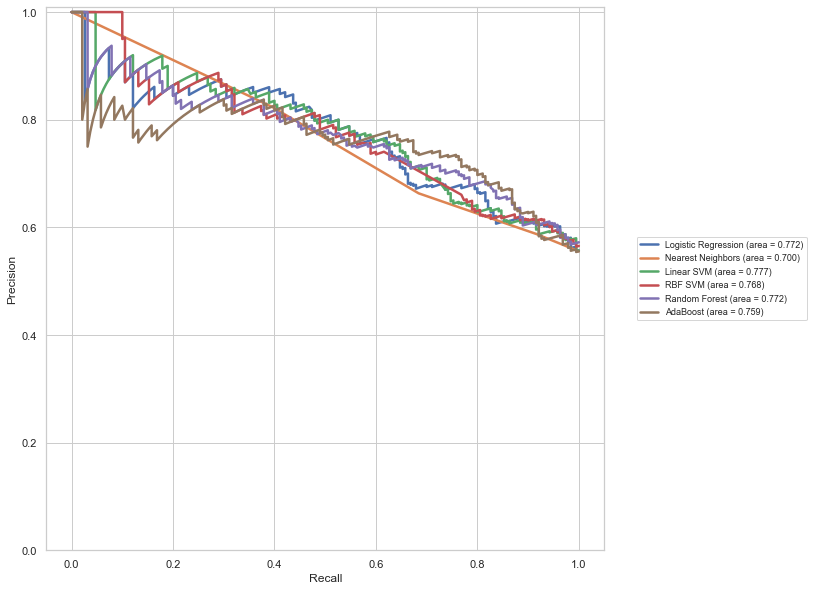

<Figure size 432x288 with 0 Axes>

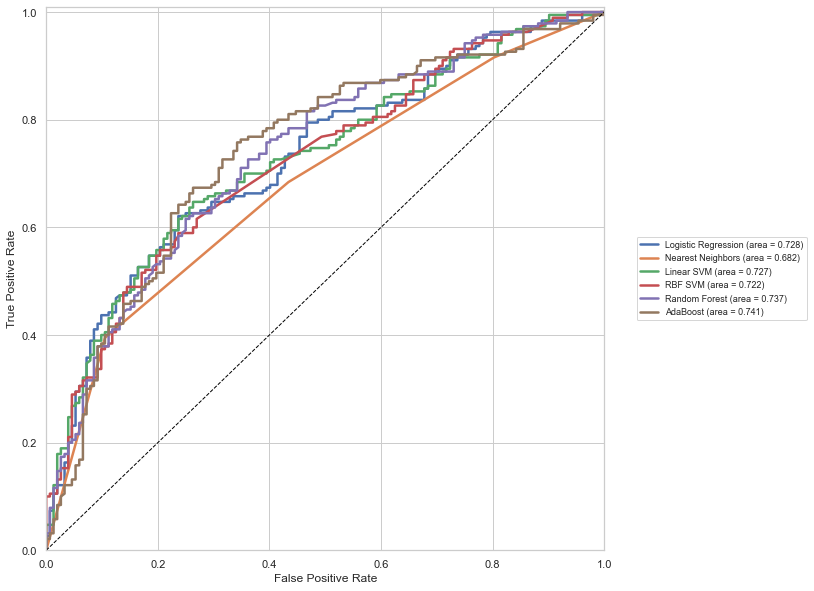

In [41]:
plot_pr(y_test, pred_prob_2020, classifier_names,10)
plot_roc(y_test, pred_prob_2020, classifier_names,10)

### Season 2020/2021:

<Figure size 432x288 with 0 Axes>

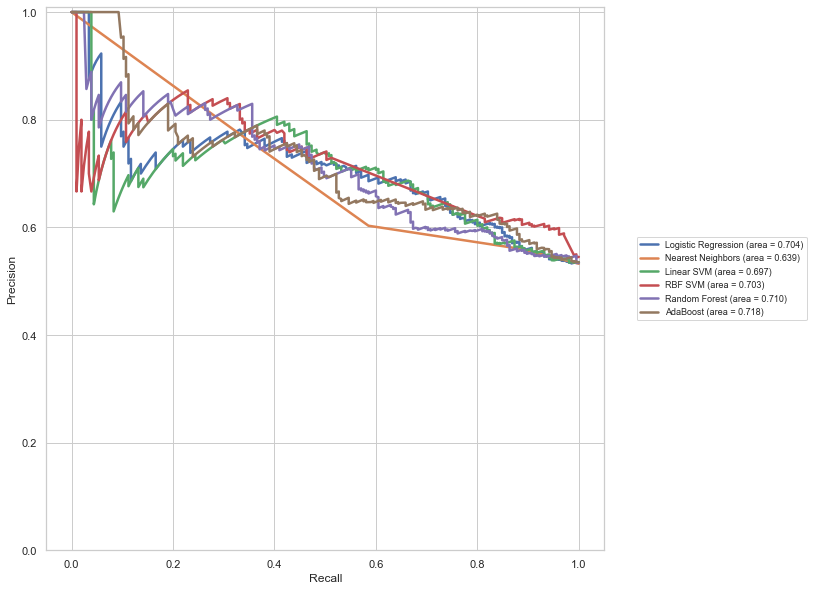

<Figure size 432x288 with 0 Axes>

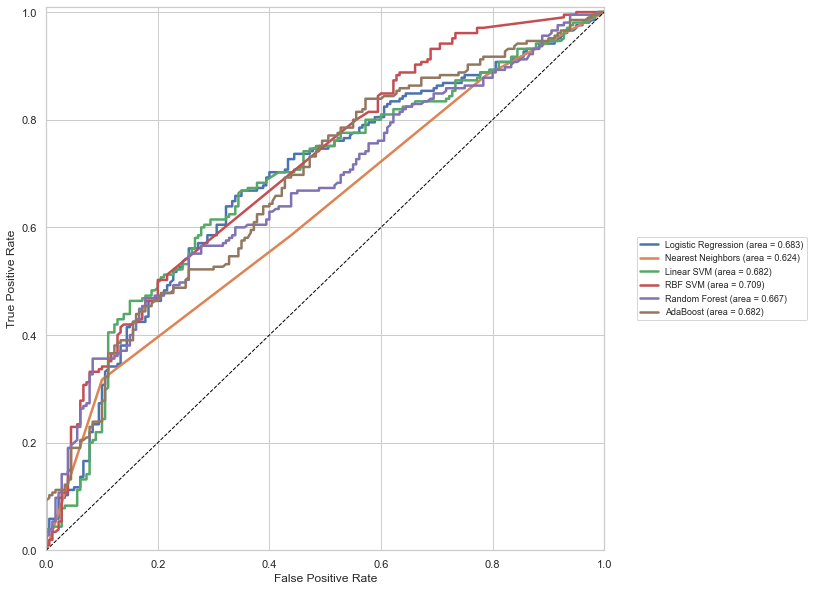

In [42]:
plot_pr(yy_test, pred_prob_2021, classifier_names,10)
plot_roc(yy_test, pred_prob_2021, classifier_names,10)

We can see that we get higher accuracy with the PR function than the ROC function in both seasons, meaning the precision is higher than the recall (we got more false negatives - a home team that we predicted that lost but actually won, than false positives - a home team we predicted than won but actually lost). Linear Support Vector Machine (SVM) performed best in the PR function of season 2019/2020, while RBF SVM performed best in the ROC function in season 2020/2021. AdaBoosts performed best in the PR fucntion of season 2020/2021, as well as in the ROC function of season 2019/2020.

We get a decent rate of accuracy, considering the data we are using (as the samples are the averages of each team and not the actual metrics per game). Our prediction worked better for season 2019/2020, which perhaps makes sense as we saw that the stronger teams had better home records in that season compared to the following one.

# 5. Matrix data visualization

We will now explore the correlation between the games key metrics and the positions of the players - what is the contriubtion of each position compared to other positions, and what are the differences between the years?

In [43]:
# Importing players stats and grouping by position for both seasons
df_players_2020_stats = pd.read_csv('players_stats_2020.csv')
players_position = df_players_2020_stats.groupby(['Pos']).sum()

df_players_2021_stats = pd.read_csv('nba_players_stats_2021.csv')
players_position_2021 = df_players_2021_stats.groupby(['Pos']).sum()

In [44]:
# Defining the metrics we are interested in

#2020
metrics_avg_2020 = df_players_2020_stats[['G','GS','MP', '3PA', '3P%', '2P', '2PA',
                                  '2P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL',
                                   'TOV', 'PTS', 'Pos']].groupby('Pos').mean().reset_index()

#2021
metrics_avg_2021 = df_players_2021_stats[['G','GS','MP', '3PA', '3P%', '2P', '2PA',
                                  '2P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL'
                                , 'TOV', 'PTS', 'Pos']].groupby('Pos').mean().reset_index()

cols_avg = ['G','GS','MP', '3PA', '3P%', '2P', '2PA',
                                  '2P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL',
                                   'TOV', 'PTS']

# Normalizing the data of each metric 
for met in cols_avg: 
    metrics_avg_2020[met] = (metrics_avg_2020[met] - metrics_avg_2020[met].mean())/metrics_avg_2020[met].std()
    metrics_avg_2021[met] = (metrics_avg_2021[met] - metrics_avg_2021[met].mean())/metrics_avg_2021[met].std()

# Setting position as index
metrics_avg_2020.set_index('Pos', inplace=True)
metrics_avg_2021.set_index('Pos', inplace=True)

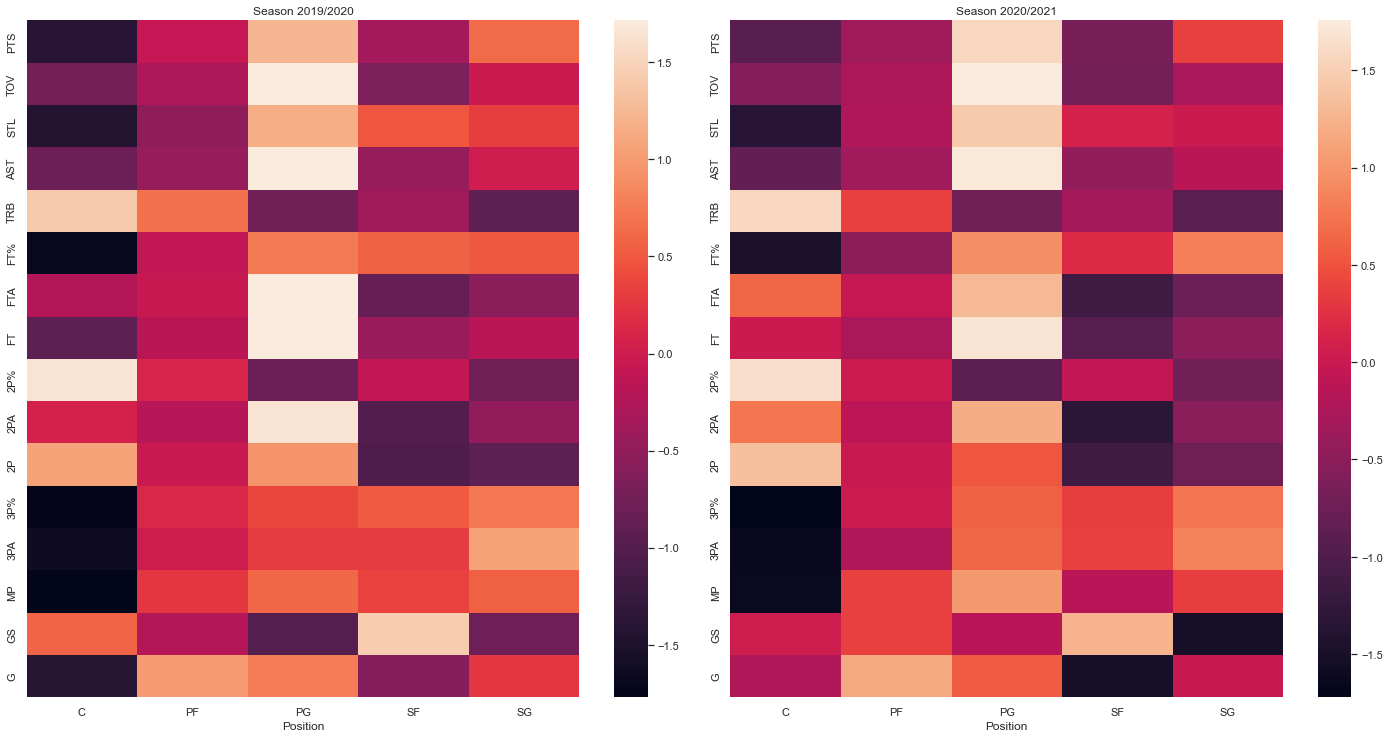

In [51]:
# Plotting both heatmaps side by side

fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1 = sns.heatmap(metrics_avg_2020.transpose(),linewidth=0,cbar=True, ax=ax1)
ax1.invert_yaxis()
ax1.set_title('Season 2019/2020')
ax1.set_xlabel('Position')

ax2 = sns.heatmap(metrics_avg_2021.transpose(),linewidth=0,cbar=True, ax=ax2)
ax2.invert_yaxis()
ax2.set_title('Season 2020/2021')
ax2.set_xlabel('Position')
plt.tight_layout()
plt.show()

While the heatmaps are similar as expected, there are a few things worth mentioning - while the dominance of guards in the league is visible, there is an increase in some key metrics for centers and forwards - perhaps a sign that players in these positions, that tradinioally would get most of their points and dominance in the paint and under the basket, are evloving and becoming more adjuted to the game, which now relies much more on 3 pointers and shooting from long range compared to the pass. Forwards and centers are gradually require also these factors today, and not only the ability to produce points close to the rim.

# 6. Dimensionality Reduction
Finally, we use dimensionality reduction to examine the dominant players in the league, to check their overall efficieny and how they are clustered with one another. We choose the 100 players that had most points on average in these seasons

In [52]:
# Importing the data for both seasons

df_top_100_players_2020 = pd.read_csv('top_100_players_2020.csv')
df_top_100_players_2021 = pd.read_csv('top_100_players_2021.csv')

df_top_100_players_2020['Player'] = df_top_100_players_2020['Player'].str.split('\\').str[0]
df_top_100_players_2021['Player'] = df_top_100_players_2021['Player'].str.split('\\').str[0]

In [53]:
def pca_function(df_players):
    ''' 
    Takes the players dataframe as an agrument, removes irrelevant columns, normalizes the data
    and then performs Prinicipal Component Analysis (PCA). Returns a concated dataframe of the
    players and the PCA dataframe
    '''
    
    # removing columns that don't indicate negative or positive effect
    df_players.drop('Pos',1, inplace=True)
    df_players.drop('Age',1, inplace=True)
    df_players.drop('Tm',1, inplace=True)
    df_players.drop('G',1, inplace=True)
    df_players.drop('GS',1, inplace=True)
    df_players.drop('MP',1, inplace=True)
    df_players.drop('Rk',1, inplace=True)
    df_players.drop('FGA',1, inplace=True)
    df_players.drop('FG',1, inplace=True)
    df_players.drop('3P',1, inplace=True)
    df_players.drop('3PA',1, inplace=True)
    df_players.drop('2P',1, inplace=True)
    df_players.drop('2PA',1, inplace=True)
    df_players.drop('FTA',1, inplace=True)
    df_players.drop('FT',1, inplace=True)

    # Defining players as indices, normalizing the dataframes and changing bad metrics to negative
    df_top_100 = df_players.set_index('Player')
    norm_top_100 = (df_top_100-df_top_100.mean())/df_top_100.std()
    norm_top_100['TOV'] = norm_top_100['TOV'] * -1
    norm_top_100['PF'] = norm_top_100['PF'] * -1
    
    # Removing nan
    norm_top_100.fillna(0, inplace=True)
    
    # Starting the dimension reduction for each season
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(norm_top_100)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    
    # Concating the top players dataframe with the principal components dataframe
    finalDf = pd.concat([principalDf, df_players[['Player']]], axis = 1)
    
    return finalDf

In [54]:
# Dataframes of both seasons with the top players after the dimensionality reduction
finalDf_2020 = pca_function(df_top_100_players_2020)
finalDf_2021 = pca_function(df_top_100_players_2021)

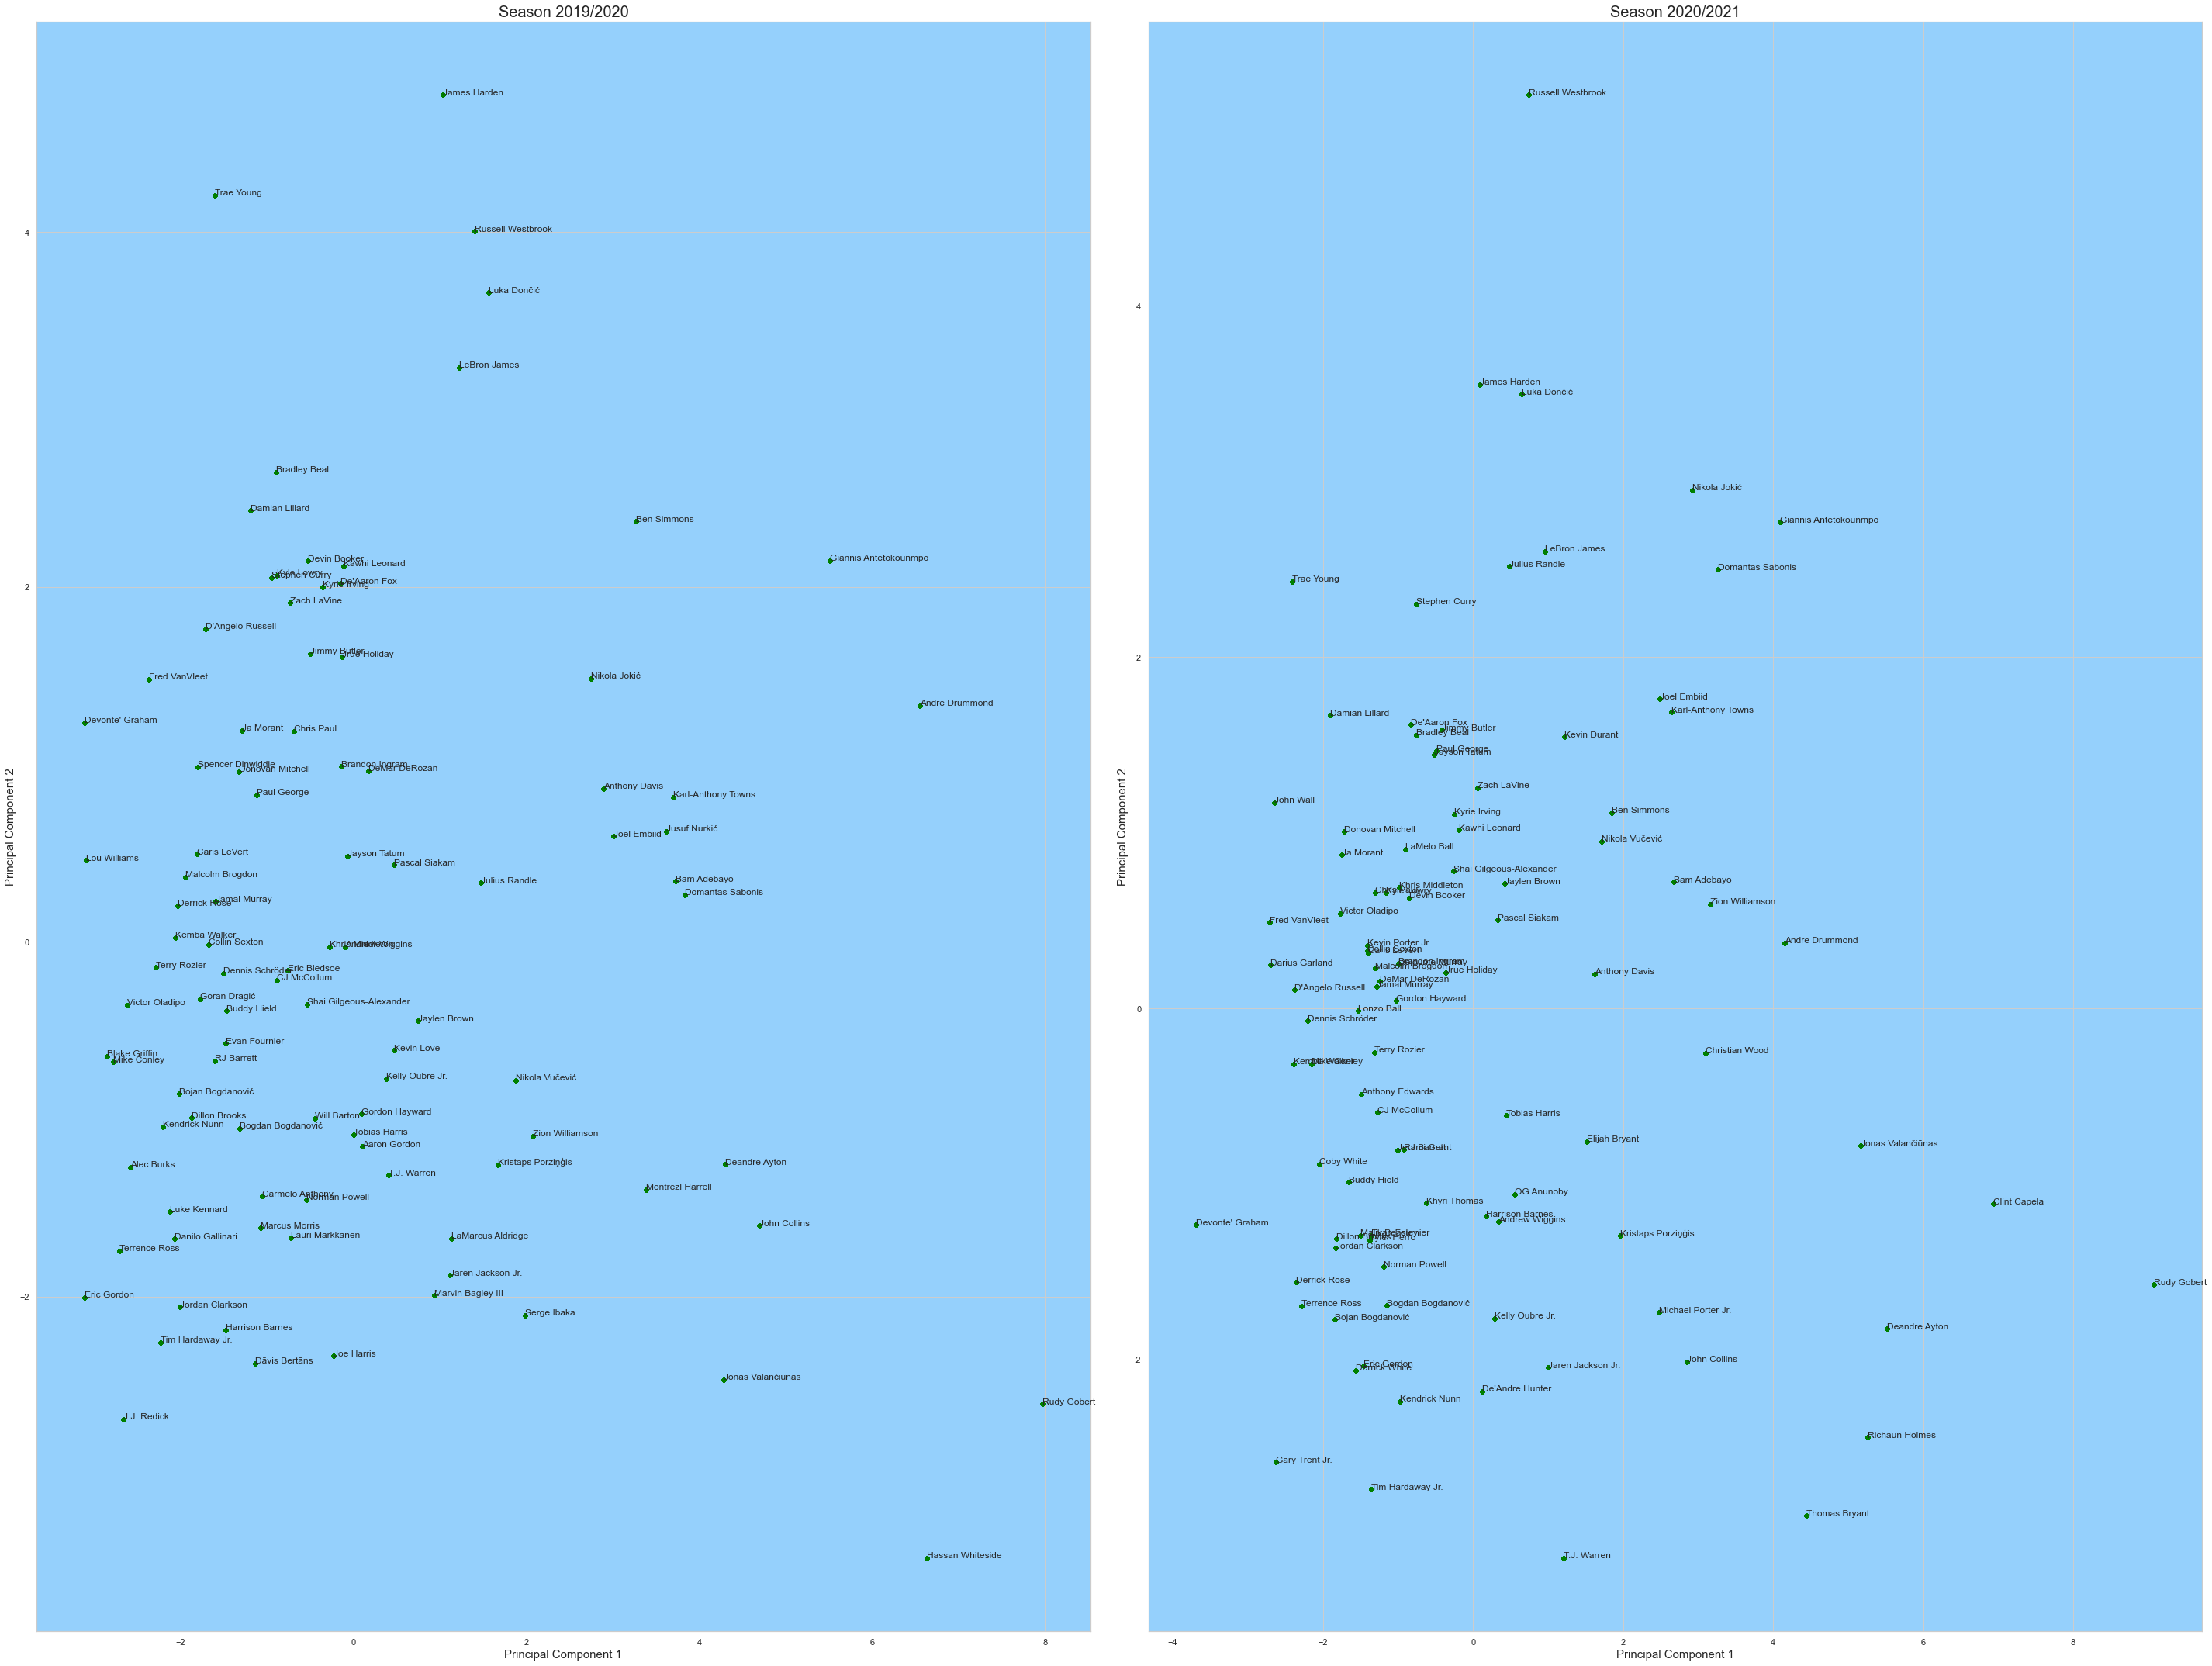

In [59]:
# Storing the players names in lists 
players_list_2020 = []
players_list_2020.extend(finalDf_2020['Player'])
players_list_2021 = []
players_list_2021.extend(finalDf_2021['Player'])

# Plotting both seasons side by side with the players names 
fig = plt.figure(figsize = (40,30))
ax = plt.subplot(1,2,1)
ax.set_facecolor('xkcd:light blue')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Season 2019/2020', fontsize = 20)

# Season 2020
for player in players_list_2020:
    indices = finalDf_2020['Player'] == player
    ax.scatter(finalDf_2020['principal component 1'],
               finalDf_2020['principal component 2'],
               c = 'green',
               s = 20)
        
for idx, row in finalDf_2020.iterrows():
    if row['Player'] in players_list_2020:
        ax.annotate(row['Player'], (row['principal component 1'], row['principal component 2']))
ax.grid()

ax1 = plt.subplot(1,2,2)
ax1.set_facecolor('xkcd:light blue')
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('Season 2020/2021', fontsize = 20)

#Season 2021
for player in players_list_2021:
    indices = finalDf_2021['Player'] == player
    ax1.scatter(finalDf_2021['principal component 1'],
               finalDf_2021['principal component 2'],
                c = 'green',
               s = 20)

for idx, row in finalDf_2021.iterrows():
    if row['Player'] in players_list_2021:
        ax1.annotate(row['Player'], (row['principal component 1'], row['principal component 2']))

plt.tight_layout()  
ax.grid()

Notice that the MVPs of the last two seasons - Nikola Jokic and Giannis Antetokounmpo - are close to each other in both seasons, and both have relatively high values in both components.

We can see that generally guards are highly ranked on Prinicpal Component 2, while forwards and centers have higher values on Principal Component 1. Rudi Gobert (a center) is considered one of the best defensive players in the league, and in both seasons has the highest value on Principal Component 1.

James Harden and Russel Westbrook are ranked highest on Prinicpal Component 2 (Harden in 2020 and Westbrook in 2021). This reflectes their amazing stats (mostly in points, assists and rebounds), though it is often questioned whether they do more harm than good for their team. Lebron James and Luca Doncic, two of the leading players in the league, are also clustered relatively close to them.

# In summary

While this was just a "tip of the iceberg" analysis, considering the amount of data that the NBA stores, it has provided some take aways that could be used for future research. We saw that despite lack of fans, the home win rate didn't change in general, but did vary vastly between the teams - this could be a solid ground to explore more of this phenomenon. 

Despite being almost the same rate as away wins, home games were a decent predictor of whether a team will win or lose, based on the averages of each team. Of course this is taken with a grain of salt considering the circumstances, the size of the dataset and the scope of the evaluation.

We also gathered some interesting findings about the contribution of each position in the league, and some small - but maybe significant - changes in the share rate of the positions between the seasons. This subject could benefit from  comparing to recent years as well. 

Finally, we used dimensionality reduction to assess and cluster the top players in the league to examine their efficency and similarities.

All in all, this analysis has produced valuable insights, and ones that could be indicators of subjects that we should look more in to and analyze in greater depth.